#Data Preparation

In [ ]:
import numpy
import math
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import LSTM

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf


pd.set_option("display.max_rows", 1000)#可显示1000行
pd.set_option("display.max_columns", 1000)#可显示1000列
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/CA683 Assignment2")
df = pd.read_csv('Premier League_2014_2022.csv')
df = df[df['ranking']!='None']

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
MOVING_AVERAGE = 5
MINIMUM_RECORD = 160

In [ ]:
dict_player = {}
dict_player_name = {}
for player_id in df['player_id'].unique():
  list_rate = list(df[df['player_id']==player_id]['ranking'].astype(float).rolling(MOVING_AVERAGE).mean())
  if(len(list_rate)>=MINIMUM_RECORD):
    dict_player[player_id] = list_rate[MOVING_AVERAGE-1:]
    dict_player_name[player_id] = df[df['player_id']==player_id]['player_name'].unique()[0]

In [ ]:
import random
test_player_list = random.sample(dict_player_name.keys(), 10)
test_player_list

[38046, 5642, 11977, 2068, 444, 1799, 11415, 15430, 4421, 6780]

In [ ]:
test_player_list = [49180, 28867, 15509, 51581, 37046, 46854, 15485, 59481, 24473, 22689]

# MODEL&CONFIG

In [ ]:
def create_inout_sequences(input_data, tw):
    feature_seq = []
    result_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]#预测time_step之后的第一个数值
        feature_seq.append(train_seq)#feature_seq内的数据不断更新，但是总量只有tw个
        result_seq.append(train_label)

    return feature_seq,result_seq
def cal_rmsle(predicted,real):
  sum=0.0
  for x in range(len(predicted)):
    p = np.log(predicted[x]+1)
    r = np.log(real[x]+1)
    sum = sum + (p - r)**2
  return (sum/len(predicted))**0.5

In [ ]:
class MODEL_CONFIG:
  TEST_DATA_SIZE = 20
  INITIAL_WINDOW = 40
  WINDOW_LENTH = 20
  Filename = './Comparison_Work/Result.csv'
  Foldername = './Comparison_Work/Pic_Comparison/'
  def __init__(self, \
        LEARNING_RATE = 0.001,\
        TIME_STEP = 10,\
        DENSE = 1,\
        NUM_NODES = 30,\
        EPOCHS = 500,\
        STRUCTURE = 'RNN',\
        OPTIMIZER = 'SGD'):
    self.LEARNING_RATE = LEARNING_RATE
    self.TIME_STEP = TIME_STEP
    self.DENSE = DENSE
    self.NUM_NODES = NUM_NODES
    self.EPOCHS = EPOCHS
    self.STRUCTURE = STRUCTURE
    if OPTIMIZER == "SGD":
      self.OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True)
    if OPTIMIZER == "ADAM":
      self.OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    if OPTIMIZER == "RMSprop":
      self.OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False)

In [ ]:
def sliding_cv_fit(data, config, cur_player_id):
  list_mae = []
  list_mse = []
  list_r2 = []
  list_rmsle = []
  list_passtime = []
  #set model
  model = Sequential()
  if config.STRUCTURE == 'RNN':
    model.add(SimpleRNN(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
  else:
    if config.STRUCTURE == 'GRU':
      model.add(GRU(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
    else:
      model.add(LSTM(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
  model.add(Dense(config.DENSE))
  model.compile(loss='mean_squared_error', optimizer=config.OPTIMIZER)


  list_train_pred = []
  list_test_pred = []

  for train_mark in range(config.INITIAL_WINDOW, (len(data)//config.WINDOW_LENTH)*config.WINDOW_LENTH, config.WINDOW_LENTH):
    data_piece = data[train_mark - config.INITIAL_WINDOW : train_mark + config.WINDOW_LENTH]
    data_seq,result_seq = create_inout_sequences(data_piece, config.TIME_STEP)
    
    train_X = np.array(data_seq[:-config.TEST_DATA_SIZE])
    test_X = np.array(data_seq[-config.TEST_DATA_SIZE:])
    train_Y = np.array(result_seq[:-config.TEST_DATA_SIZE])
    test_Y = np.array(result_seq[-config.TEST_DATA_SIZE:])
    
    train_X = np.reshape(train_X, (train_X.shape[0],1,train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0],1,test_X.shape[1]))

    T1 = time.time()
    model.fit(train_X, train_Y, epochs=config.EPOCHS, batch_size=1, verbose=0)
    pass_time = time.time() - T1

    trainPredict = model(train_X)
    testPredict = model(test_X)
    if train_mark == config.INITIAL_WINDOW:
      list_train_pred = list_train_pred + list(trainPredict[:,0])
    else:
      list_train_pred = list_train_pred + list(trainPredict[:,0][-config.WINDOW_LENTH:])

    list_test_pred = list_test_pred + list(testPredict[:,0])

    list_mae.append(mean_absolute_error(test_Y, testPredict))
    list_mse.append(mean_squared_error(test_Y, testPredict))
    list_r2.append(r2_score(test_Y, testPredict))
    list_rmsle.append(cal_rmsle(test_Y, testPredict))
    list_passtime.append(pass_time)
  #create figure
  fig_len = len(data) // 10 + 2
  plt.figure(figsize=[fig_len,6])
  plt.plot(range(0,len(data)),data,color='blue')
  len_trainP = len(list_train_pred)
  len_testP = len(list_test_pred)
  plt.plot(range(config.TIME_STEP,config.TIME_STEP+len_trainP),list_train_pred,color='orange')
  plt.plot(range(config.INITIAL_WINDOW,config.INITIAL_WINDOW+len_testP),list_test_pred,color='red')
  plt.legend(['Real', 'Train Predict', 'Test Predict'],loc='best')
  plt.title('Performance of ' + dict_player_name[cur_player_id])

  plt.savefig(config.Foldername + str(cur_player_id) + '.jpg')
  print('\nSave fig to:' + config.Foldername + str(cur_player_id) + '.jpg')
  #plt.show()

  return np.mean(list_mae),np.mean(list_mse),np.mean(list_r2),np.mean(list_rmsle),np.mean(list_passtime)

#RNN

In [ ]:
df_RNN_para = pd.read_csv('./Comparison_Work/RNN_ParaResultCV.csv')
df_RNN_para = df_RNN_para.sort_values(by="MSE",ascending=True)
print(df_RNN_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
9           0.001          6      1         40     400      ADAM          NaN   
21          0.001          7      1         40     400      ADAM          NaN   
3           0.001          6      1         20     500      ADAM          NaN   
23          0.001          7      1         40     500      ADAM          NaN   
7           0.001          6      1         30     500      ADAM          NaN   

         MAE       MSE     RMSLE        R2  
9   0.187822  0.065101  0.030805  0.514504  
21  0.205720  0.071732  0.033416  0.327540  
3   0.218230  0.072009  0.034048  0.234984  
23  0.206363  0.074220  0.032909  0.368549  
7   0.218965  0.074643  0.034163  0.258224  


In [ ]:
config_RNN = MODEL_CONFIG(0.001,6,1,40,400,'RNN','ADAM')
config_RNN.Filename = './Comparison_Work/RNN_Result.csv'
config_RNN.Foldername = './Comparison_Work/Pic_RNN/'

 10%|█         | 1/10 [04:25<39:47, 265.27s/it]


Save fig to:./Comparison_Work/Pic_RNN/49180.jpg

	TIME_PER_TRAIN(Second):44.09085210164388

	MAE:0.22636963431040436
	MSE:0.08170662356383453
	R2:0.6563180864447143
	RMSLE:0.034422474789550246


 20%|██        | 2/10 [08:15<32:39, 244.95s/it]


Save fig to:./Comparison_Work/Pic_RNN/28867.jpg

	TIME_PER_TRAIN(Second):32.890171902520315

	MAE:0.18647546563829706
	MSE:0.0555087927140624
	R2:0.2669823437558925
	RMSLE:0.030943835920504054


 30%|███       | 3/10 [11:53<27:06, 232.29s/it]


Save fig to:./Comparison_Work/Pic_RNN/15509.jpg

	TIME_PER_TRAIN(Second):24.07493895954556

	MAE:0.19389637035793728
	MSE:0.05609637337532816
	R2:0.008536708259716788
	RMSLE:0.02986970959983682


 40%|████      | 4/10 [16:00<23:49, 238.18s/it]


Save fig to:./Comparison_Work/Pic_RNN/51581.jpg

	TIME_PER_TRAIN(Second):41.12126954396566

	MAE:0.16099204492568966
	MSE:0.04992982619709315
	R2:0.2818512592937302
	RMSLE:0.027923709892929444


 50%|█████     | 5/10 [20:53<21:30, 258.08s/it]


Save fig to:./Comparison_Work/Pic_RNN/37046.jpg

	TIME_PER_TRAIN(Second):32.532378938463

	MAE:0.22371269724104137
	MSE:0.07504608275795181
	R2:0.4102402227575377
	RMSLE:0.03425410893211059


 60%|██████    | 6/10 [23:02<14:15, 213.92s/it]


Save fig to:./Comparison_Work/Pic_RNN/46854.jpg

	TIME_PER_TRAIN(Second):25.558209037780763

	MAE:0.24485965652465821
	MSE:0.08500713233839034
	R2:-0.24813621463131294
	RMSLE:0.03719308065842538


 70%|███████   | 7/10 [27:30<11:35, 231.76s/it]


Save fig to:./Comparison_Work/Pic_RNN/15485.jpg

	TIME_PER_TRAIN(Second):38.28189563751221

	MAE:0.17503801046098982
	MSE:0.05317157762741961
	R2:0.4136978895830924
	RMSLE:0.03106786221701336


 80%|████████  | 8/10 [31:21<07:42, 231.39s/it]


Save fig to:./Comparison_Work/Pic_RNN/59481.jpg

	TIME_PER_TRAIN(Second):32.86352954592024

	MAE:0.1936546622685024
	MSE:0.062298270752229094
	R2:0.4882518163358426
	RMSLE:0.03085446322408466


 90%|█████████ | 9/10 [35:30<03:57, 237.13s/it]


Save fig to:./Comparison_Work/Pic_RNN/24473.jpg

	TIME_PER_TRAIN(Second):35.608244385038105

	MAE:0.21175539452689038
	MSE:0.06843517438886067
	R2:-0.12865728132576068
	RMSLE:0.03370239294718968


100%|██████████| 10/10 [38:43<00:00, 232.34s/it]


Save fig to:./Comparison_Work/Pic_RNN/22689.jpg

	TIME_PER_TRAIN(Second):27.432892901556833

	MAE:0.21795686858040947
	MSE:0.08198318758506525
	R2:-0.5435643095238007
	RMSLE:0.03579973096101404


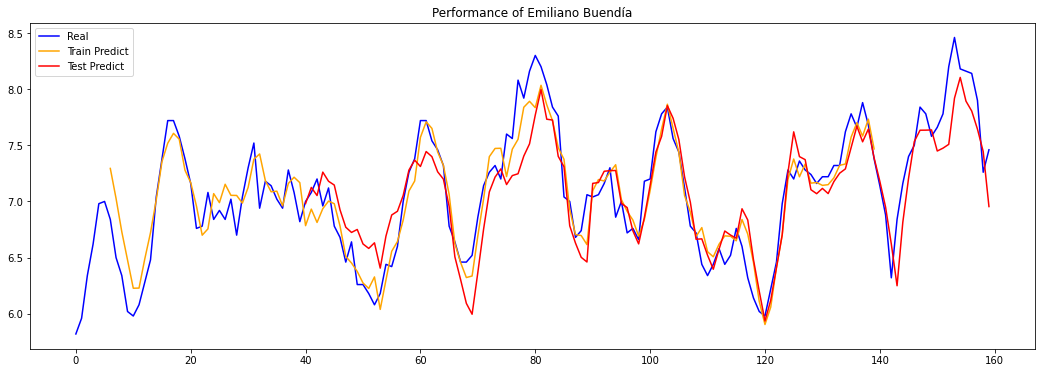

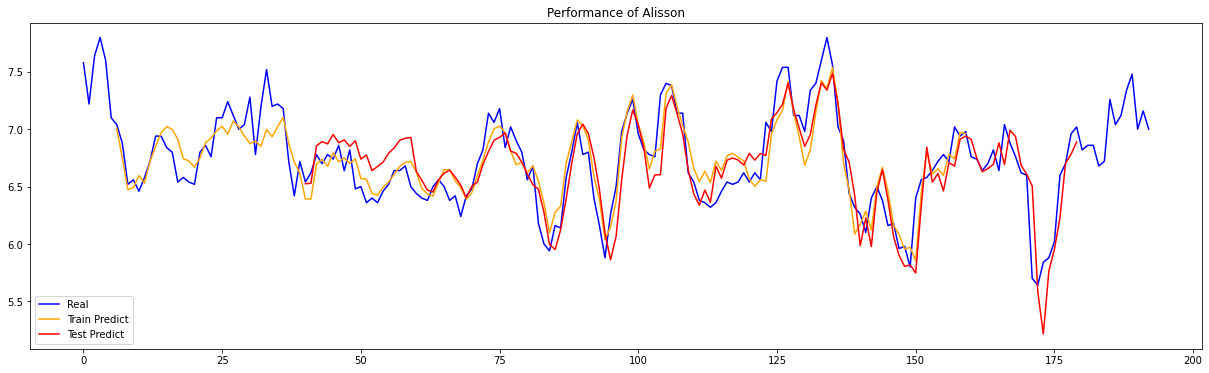

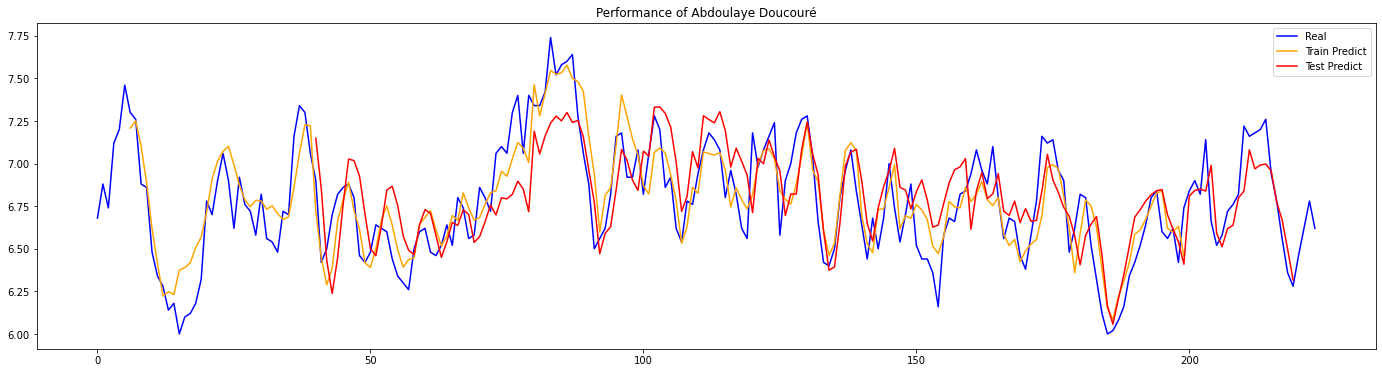

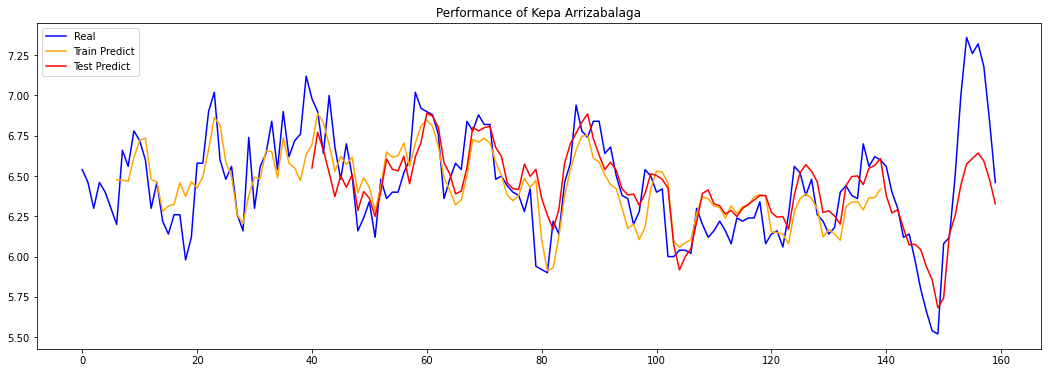

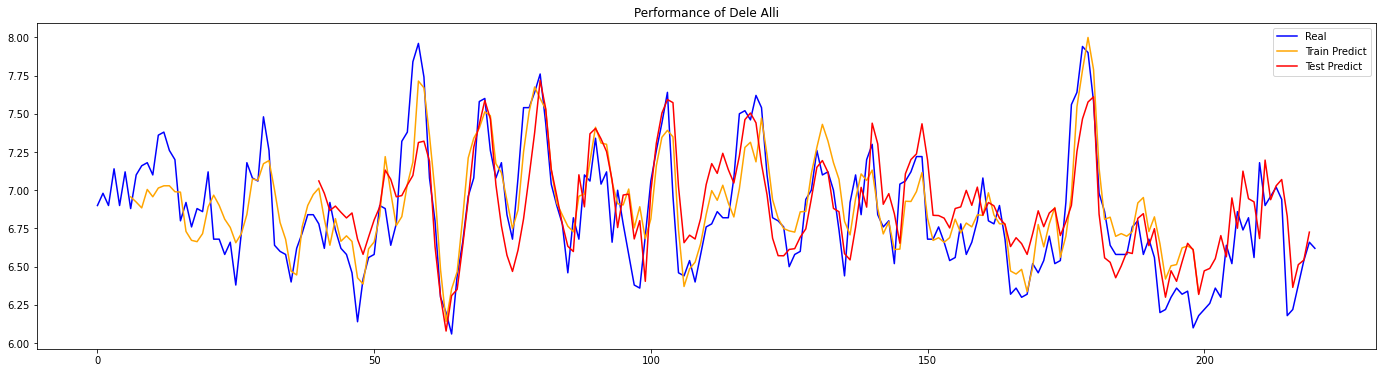

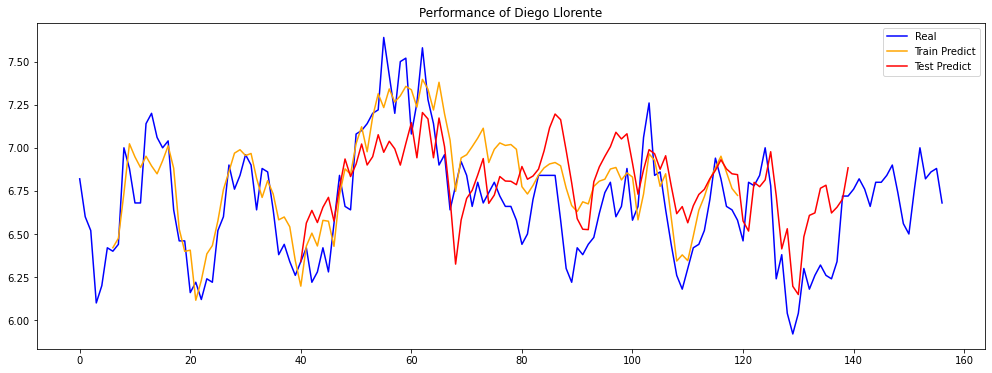

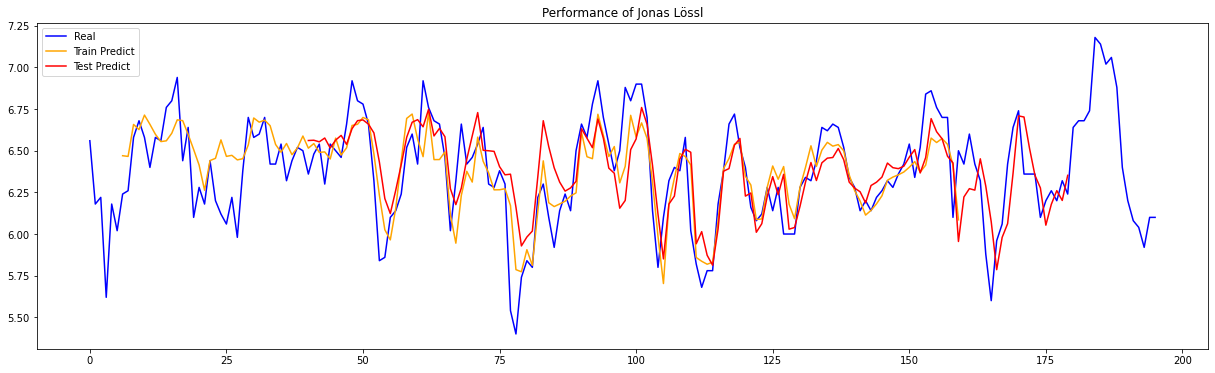

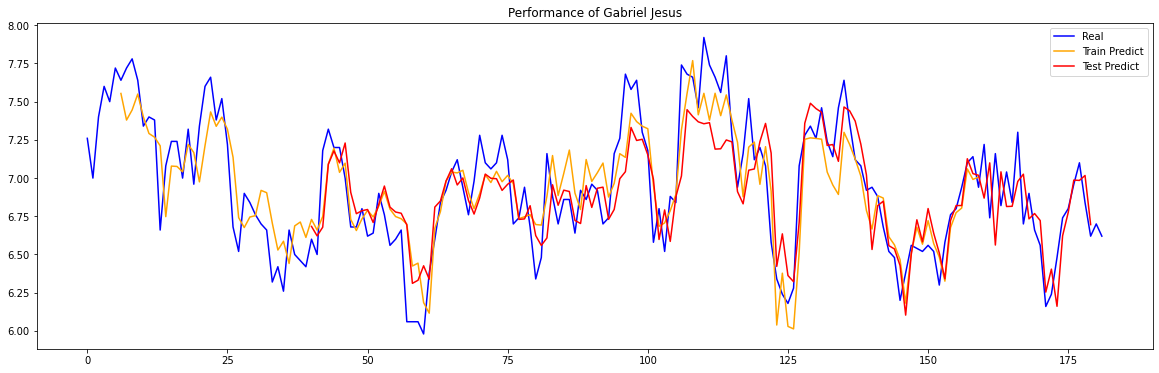

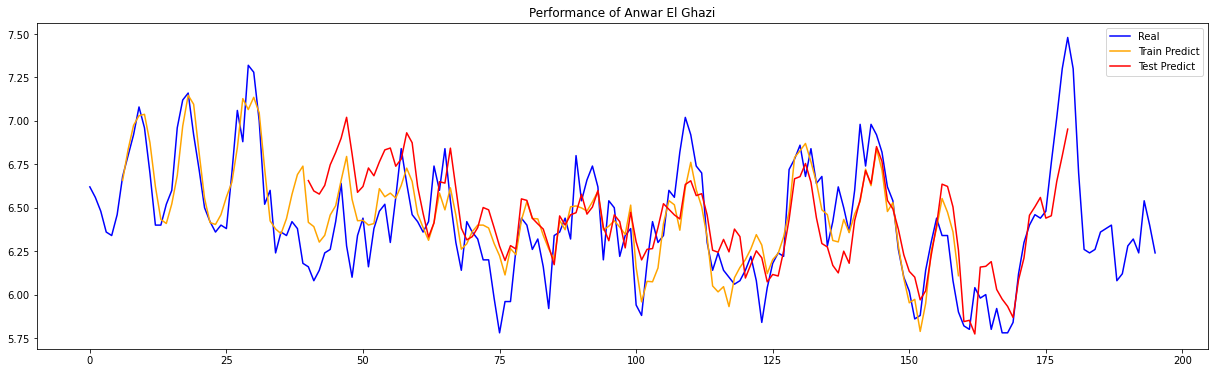

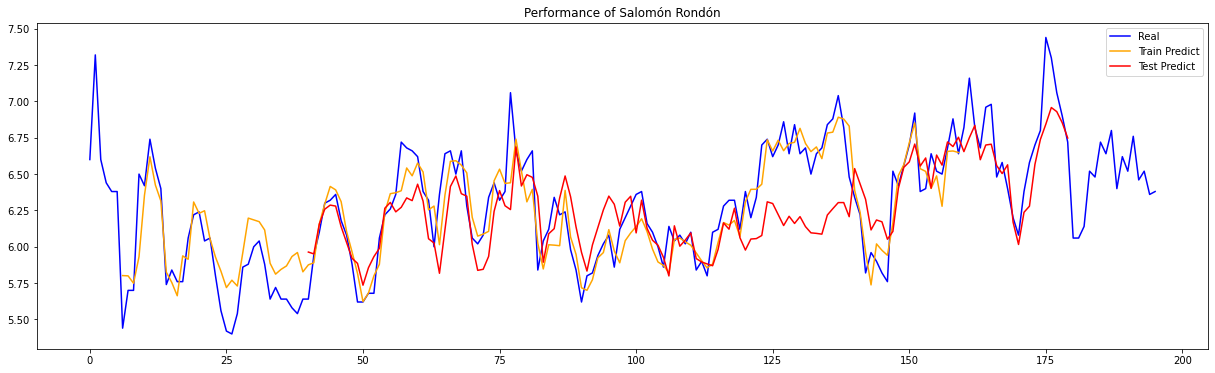

In [ ]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_RNN, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_RNN.Filename,index=0)

#GRU

In [ ]:
df_GRU_para = pd.read_csv('./Comparison_Work/GRU_ParaResultCV.csv')
df_GRU_para = df_GRU_para.sort_values(by="MSE",ascending=True)
print(df_GRU_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
11          0.001          6      1         40     500      ADAM          NaN   
28          0.001          8      1         30     400       SGD          NaN   
23          0.001          7      1         40     500      ADAM          NaN   
9           0.001          6      1         40     400      ADAM          NaN   
7           0.001          6      1         30     500      ADAM          NaN   

         MAE       MSE     RMSLE        R2  
11  0.187576  0.061778  0.030586  0.512846  
28  0.190322  0.062103  0.031119  0.454427  
23  0.196848  0.062525  0.031652  0.370999  
9   0.189588  0.062596  0.030822  0.501661  
7   0.193299  0.062757  0.031032  0.417338  


In [ ]:
config_GRU = MODEL_CONFIG(0.001,6,1,40,500,'GRU','ADAM')
config_GRU.Filename = './Comparison_Work/GRU_Result.csv'
config_GRU.Foldername = './Comparison_Work/Pic_GRU/'

 10%|█         | 1/10 [03:45<33:46, 225.20s/it]


Save fig to:./Comparison_Work/Pic_GRU/49180.jpg

	TIME_PER_TRAIN(Second):37.374401926994324

	MAE:0.2149163239796956
	MSE:0.07458766284606122
	R2:0.7044787672168749
	RMSLE:0.0326789394346826


 20%|██        | 2/10 [08:00<32:25, 243.16s/it]


Save fig to:./Comparison_Work/Pic_GRU/28867.jpg

	TIME_PER_TRAIN(Second):36.41802566392081

	MAE:0.200312508719308
	MSE:0.06176816726038905
	R2:0.02928588845654239
	RMSLE:0.03202718277295052


 30%|███       | 3/10 [13:32<33:05, 283.62s/it]


Save fig to:./Comparison_Work/Pic_GRU/15509.jpg

	TIME_PER_TRAIN(Second):36.768464697731865

	MAE:0.17521932135687937
	MSE:0.04550555659620376
	R2:0.22245495139519406
	RMSLE:0.02703512246429255


 40%|████      | 4/10 [17:17<26:03, 260.53s/it]


Save fig to:./Comparison_Work/Pic_GRU/51581.jpg

	TIME_PER_TRAIN(Second):37.397479017575584

	MAE:0.15219260231653853
	MSE:0.044761426489470825
	R2:0.39919465168970164
	RMSLE:0.026434357774528686


 50%|█████     | 5/10 [23:14<24:35, 295.07s/it]


Save fig to:./Comparison_Work/Pic_GRU/37046.jpg

	TIME_PER_TRAIN(Second):39.4950655831231

	MAE:0.2152006434334649
	MSE:0.06963973786139195
	R2:0.4147237457973651
	RMSLE:0.032749167842355716


 60%|██████    | 6/10 [26:33<17:29, 262.47s/it]


Save fig to:./Comparison_Work/Pic_GRU/46854.jpg

	TIME_PER_TRAIN(Second):39.70312376022339

	MAE:0.19063878364562986
	MSE:0.05744667917419394
	R2:0.2216240487738042
	RMSLE:0.030475640494173516


 70%|███████   | 7/10 [30:42<12:54, 258.20s/it]


Save fig to:./Comparison_Work/Pic_GRU/15485.jpg

	TIME_PER_TRAIN(Second):35.526770898274016

	MAE:0.16604375662122456
	MSE:0.05106511702375519
	R2:0.43487440839990715
	RMSLE:0.030598029811463867


 80%|████████  | 8/10 [34:57<08:34, 257.18s/it]


Save fig to:./Comparison_Work/Pic_GRU/59481.jpg

	TIME_PER_TRAIN(Second):36.32066249847412

	MAE:0.21619890935080407
	MSE:0.07923618286137446
	R2:0.3712690605777485
	RMSLE:0.03410903870718599


 90%|█████████ | 9/10 [39:03<04:13, 253.47s/it]


Save fig to:./Comparison_Work/Pic_GRU/24473.jpg

	TIME_PER_TRAIN(Second):34.89034611838205

	MAE:0.1977290085383824
	MSE:0.059823341215707225
	R2:0.03220492819502436
	RMSLE:0.03167057660193448


100%|██████████| 10/10 [43:44<00:00, 262.42s/it]


Save fig to:./Comparison_Work/Pic_GRU/22689.jpg

	TIME_PER_TRAIN(Second):40.04373969350542

	MAE:0.21894898223876955
	MSE:0.07623217433794348
	R2:-0.4266712460497938
	RMSLE:0.03629023302364921


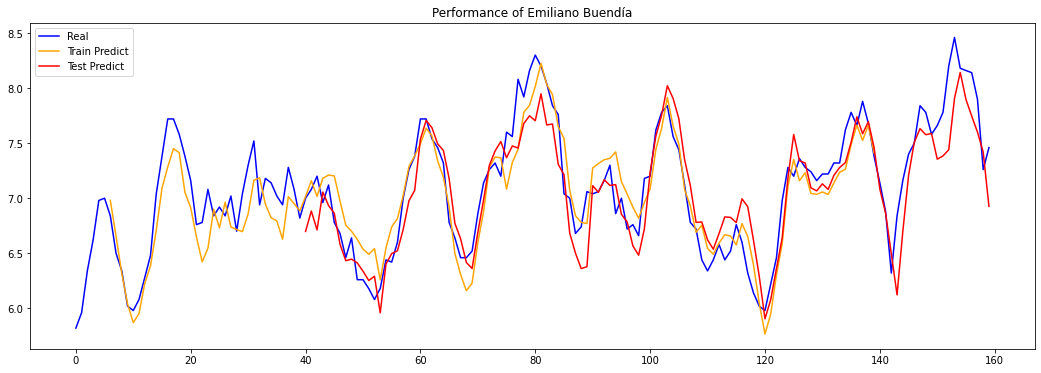

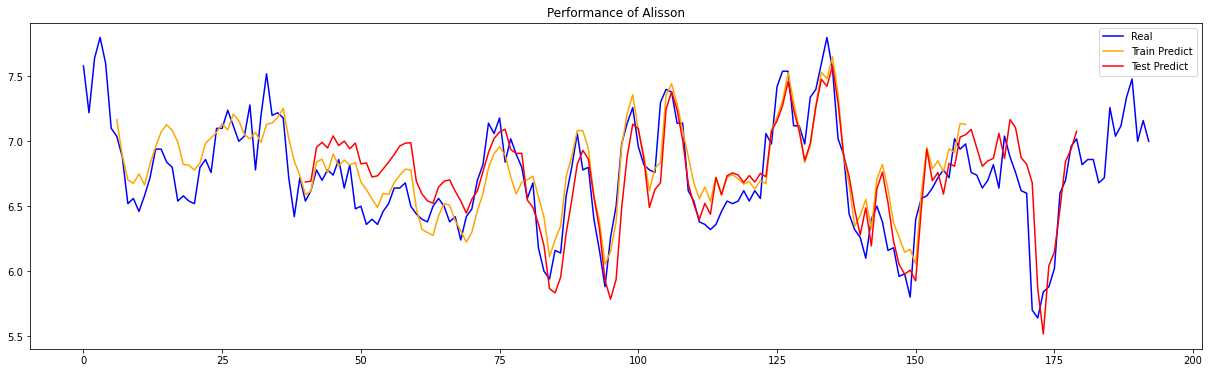

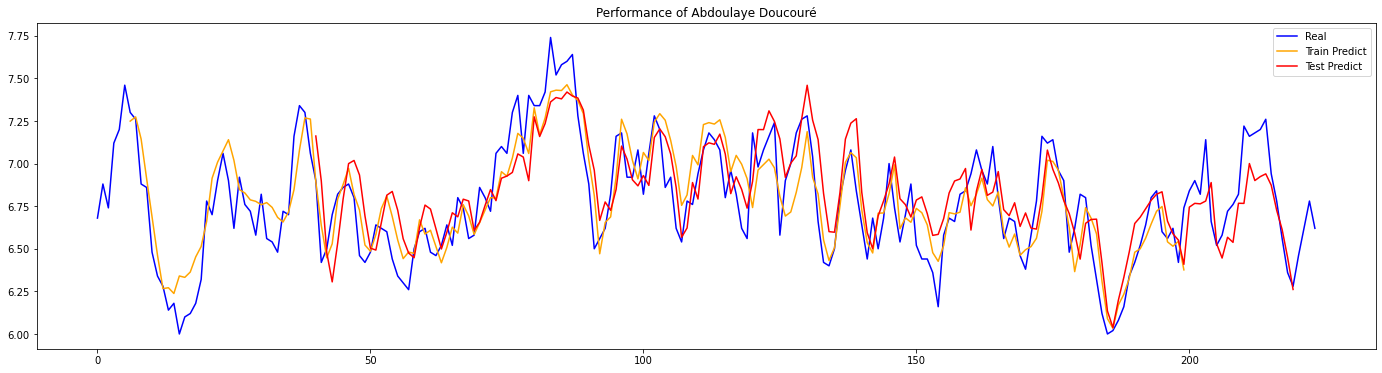

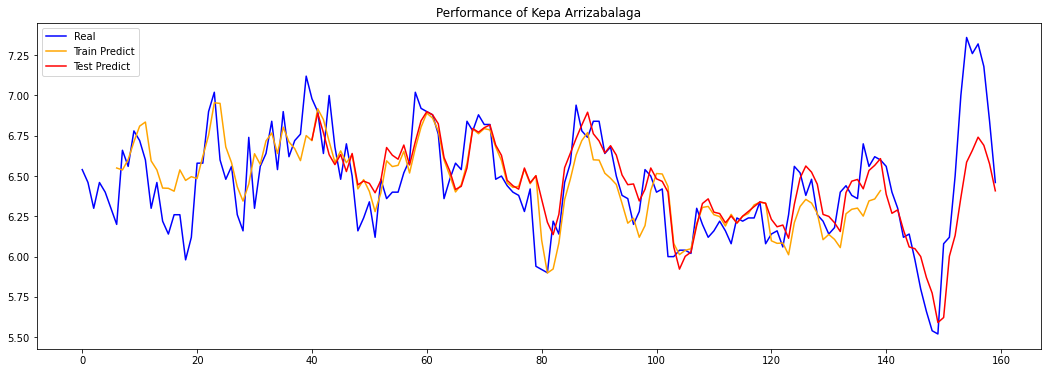

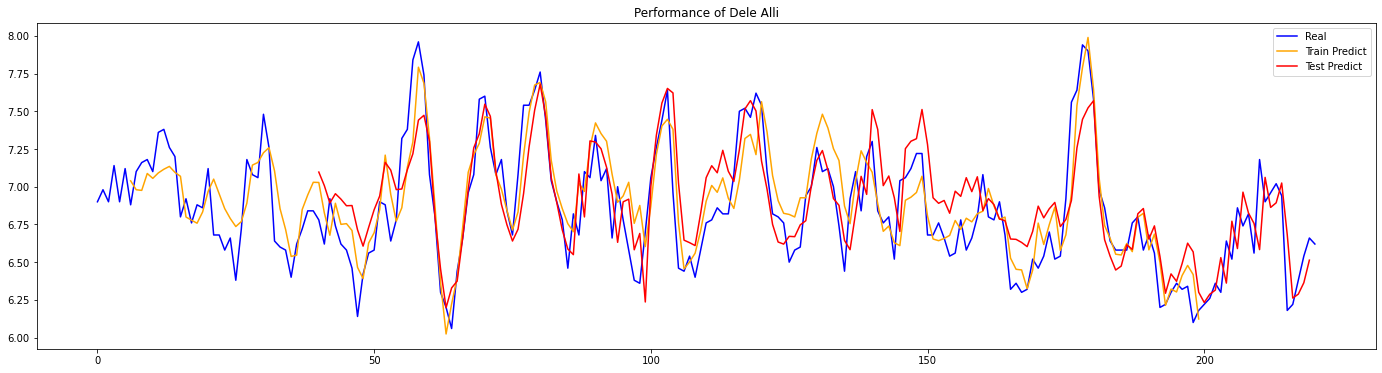

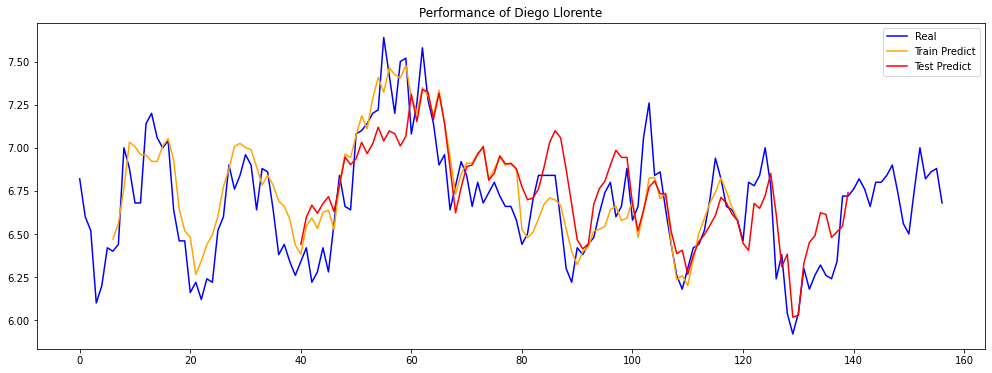

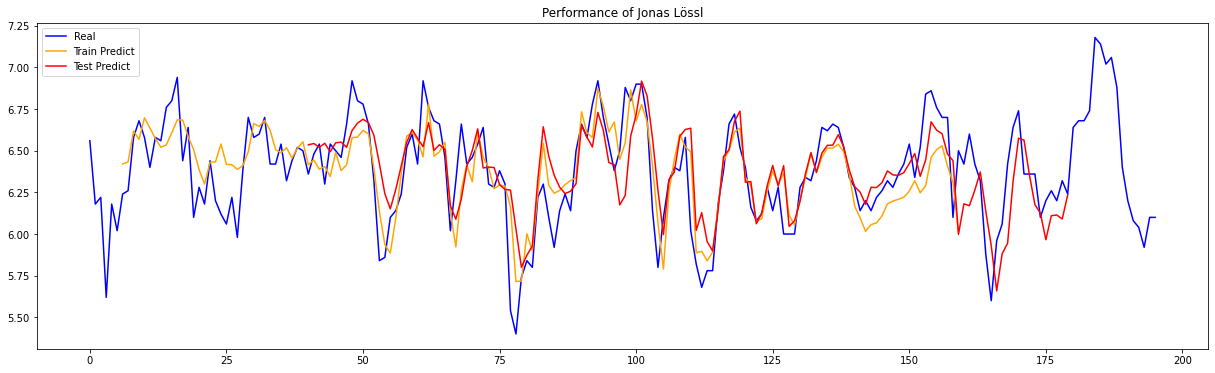

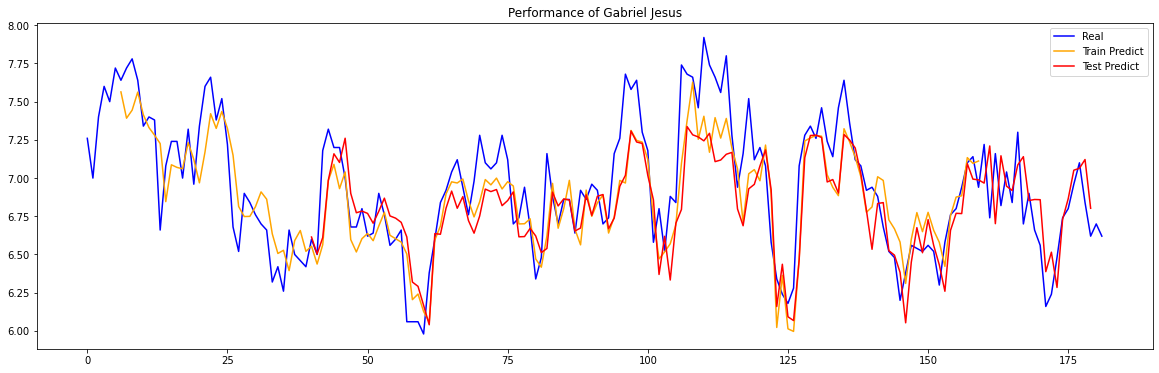

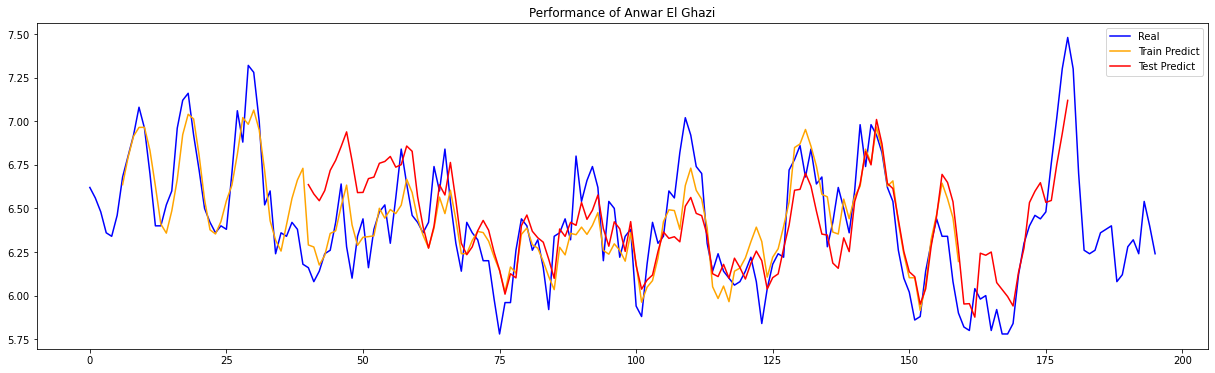

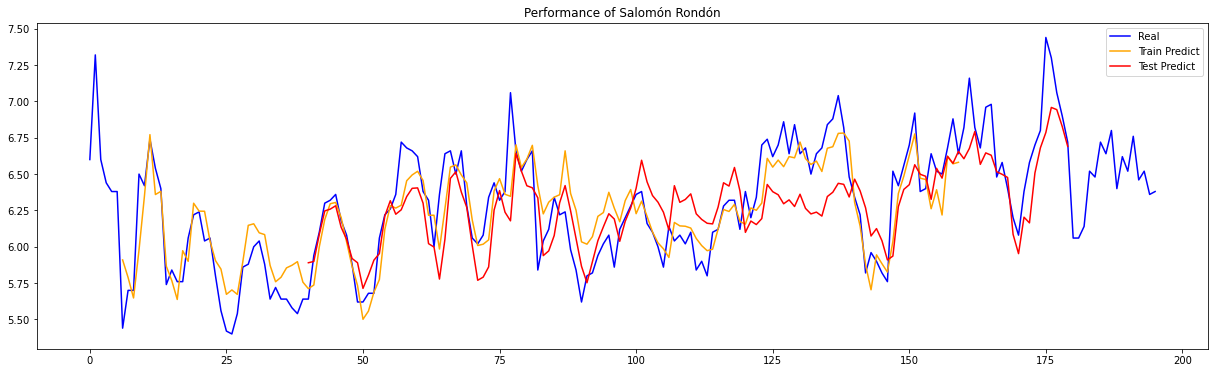

In [ ]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_GRU, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_GRU.Filename,index=0)

#LSTM

In [26]:
df_para = pd.read_csv('ParaResultCV.csv')
df_para = df_para.sort_values(by="MSE",ascending=True)
print(df_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
23          0.001          7      1         20     500      ADAM          NaN   
34          0.001          7      1         40     500       SGD          NaN   
9           0.001          6      1         30     400      ADAM          NaN   
3           0.001          6      1         20     400      ADAM          NaN   
32          0.001          7      1         40     400       SGD          NaN   

         MAE       MSE     RMSLE        R2  
23  0.179809  0.055023  0.029342  0.516331  
34  0.185452  0.057287  0.030016  0.476154  
9   0.188581  0.059201  0.030295  0.502503  
3   0.189823  0.061629  0.030634  0.485452  
32  0.189335  0.062664  0.030677  0.485385  


In [27]:
config_LSTM = MODEL_CONFIG(0.001,7,1,20,500,'LSTM','ADAM')
config_LSTM.Filename = './Comparison_Work/LSTM_Result.csv'
config_LSTM.Foldername = './Comparison_Work/Pic_LSTM/'

 10%|█         | 1/10 [03:53<35:03, 233.75s/it]


Save fig to:./Comparison_Work/Pic_LSTM/49180.jpg

	TIME_PER_TRAIN(Second):38.823224782943726

	MAE:0.2296497168540954
	MSE:0.08207131140505845
	R2:0.670880979399878
	RMSLE:0.034423553653377514


 20%|██        | 2/10 [08:34<34:51, 261.47s/it]


Save fig to:./Comparison_Work/Pic_LSTM/28867.jpg

	TIME_PER_TRAIN(Second):40.006971733910696

	MAE:0.19287178366524846
	MSE:0.05848242937548182
	R2:0.12193736888830756
	RMSLE:0.031397417202018316


 30%|███       | 3/10 [13:53<33:34, 287.72s/it]


Save fig to:./Comparison_Work/Pic_LSTM/15509.jpg

	TIME_PER_TRAIN(Second):35.341322077645195

	MAE:0.20746335739559596
	MSE:0.06459401868489957
	R2:-0.19581184173285035
	RMSLE:0.032047442293747126


 40%|████      | 4/10 [17:36<26:13, 262.24s/it]


Save fig to:./Comparison_Work/Pic_LSTM/51581.jpg

	TIME_PER_TRAIN(Second):37.06206695238749

	MAE:0.18580196158091225
	MSE:0.05656370092646565
	R2:-0.06492876067838628
	RMSLE:0.030373319197221055


 50%|█████     | 5/10 [22:59<23:39, 283.91s/it]


Save fig to:./Comparison_Work/Pic_LSTM/37046.jpg

	TIME_PER_TRAIN(Second):35.71676807933383

	MAE:0.20558797454833988
	MSE:0.06790769206211174
	R2:0.5114618557687813
	RMSLE:0.03249183758439831


 60%|██████    | 6/10 [26:18<17:00, 255.15s/it]


Save fig to:./Comparison_Work/Pic_LSTM/46854.jpg

	TIME_PER_TRAIN(Second):39.72327017784119

	MAE:0.20067851943969725
	MSE:0.06661752494461963
	R2:0.15931026708973545
	RMSLE:0.03264383557677944


 70%|███████   | 7/10 [30:51<13:03, 261.05s/it]


Save fig to:./Comparison_Work/Pic_LSTM/15485.jpg

	TIME_PER_TRAIN(Second):38.91114865030561

	MAE:0.195348004749843
	MSE:0.06841414354269083
	R2:0.19689093072294206
	RMSLE:0.03506446478886389


 80%|████████  | 8/10 [35:15<08:44, 262.02s/it]


Save fig to:./Comparison_Work/Pic_LSTM/59481.jpg

	TIME_PER_TRAIN(Second):37.60888341494969

	MAE:0.19516941942487429
	MSE:0.06054984828618607
	R2:0.4492230093905064
	RMSLE:0.030953644619069333


 90%|█████████ | 9/10 [39:48<04:25, 265.52s/it]


Save fig to:./Comparison_Work/Pic_LSTM/24473.jpg

	TIME_PER_TRAIN(Second):38.911194052015034

	MAE:0.21584611633845732
	MSE:0.0746416064157726
	R2:-0.2254579592742471
	RMSLE:0.03505620216298551


100%|██████████| 10/10 [44:22<00:00, 266.24s/it]


Save fig to:./Comparison_Work/Pic_LSTM/22689.jpg

	TIME_PER_TRAIN(Second):38.95814200810024

	MAE:0.21840173530578608
	MSE:0.0774381957493964
	R2:-0.4184760342576814
	RMSLE:0.03549315628124878


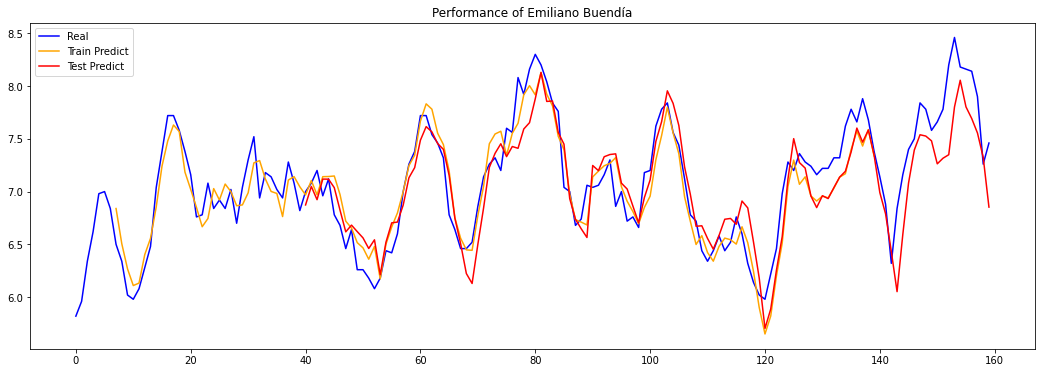

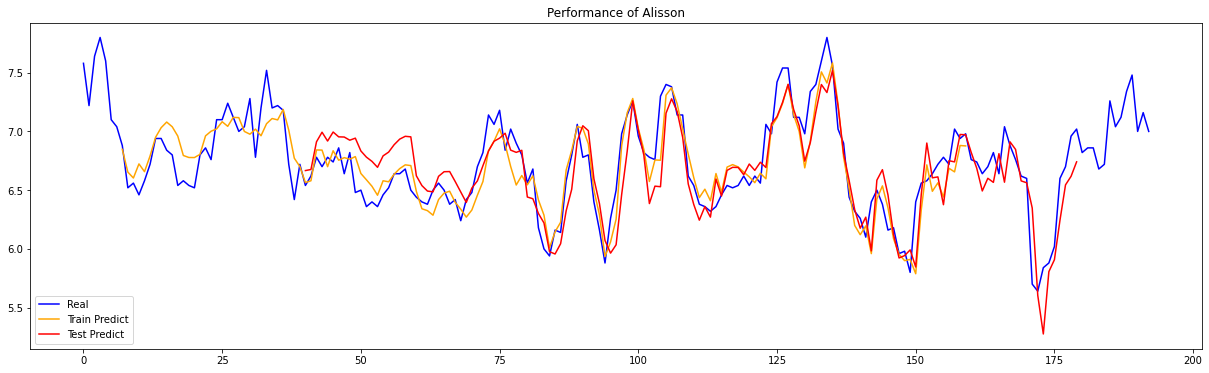

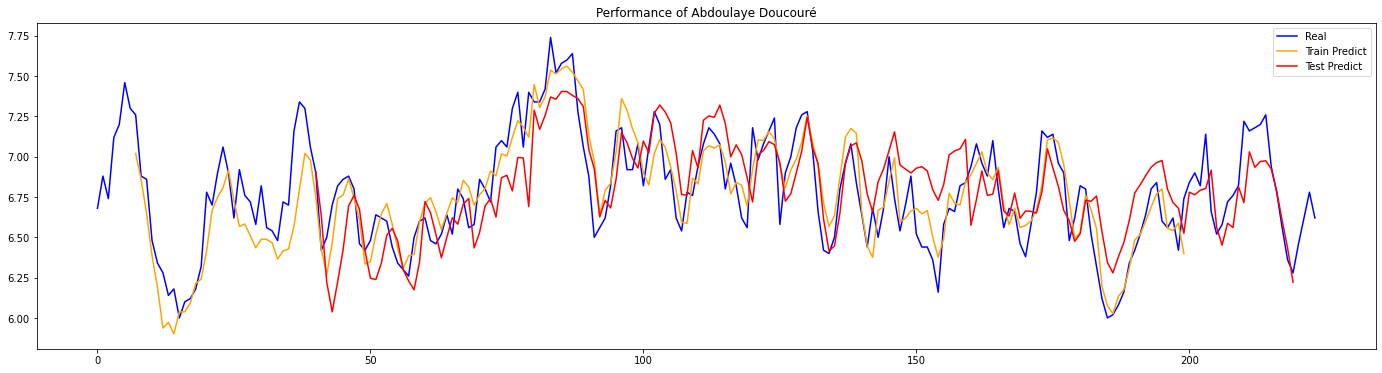

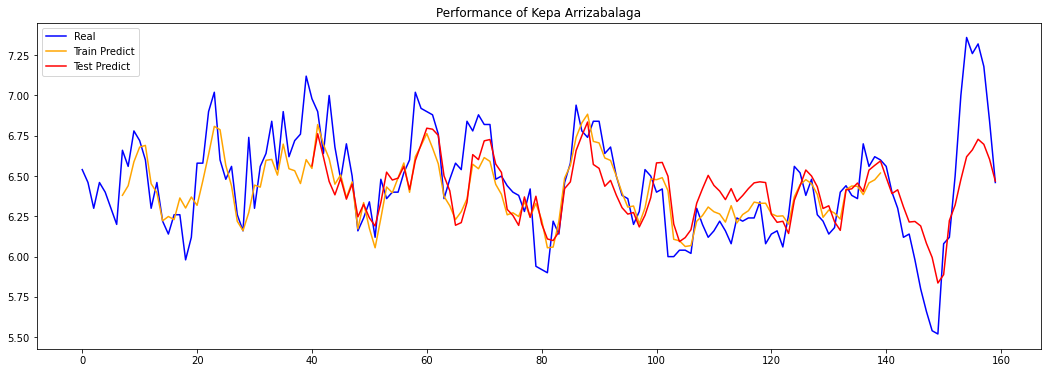

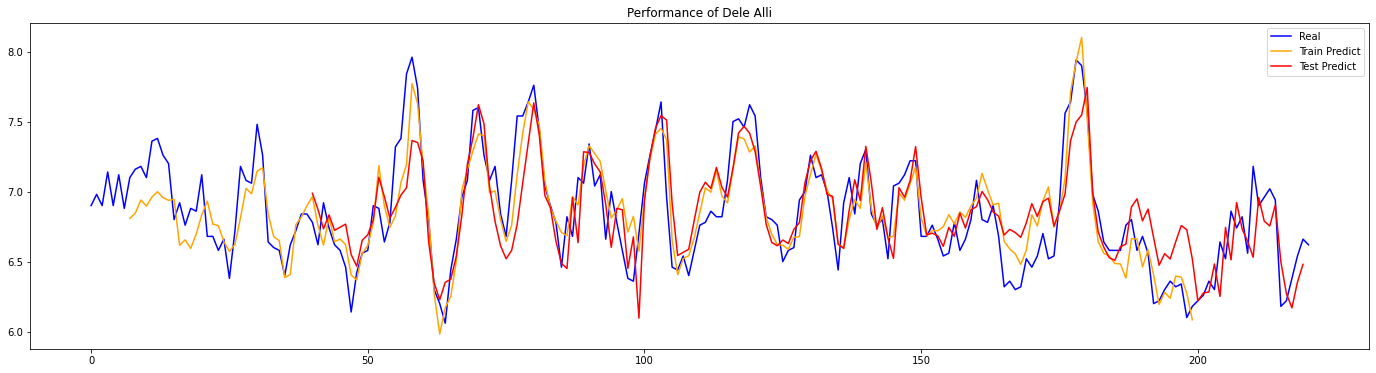

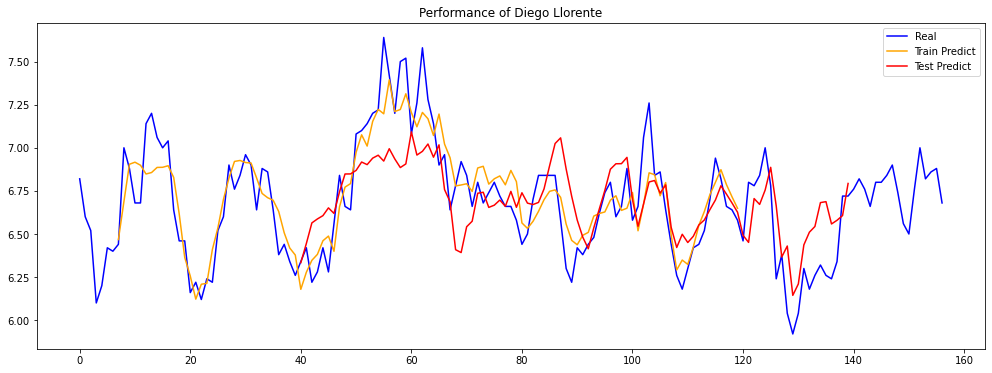

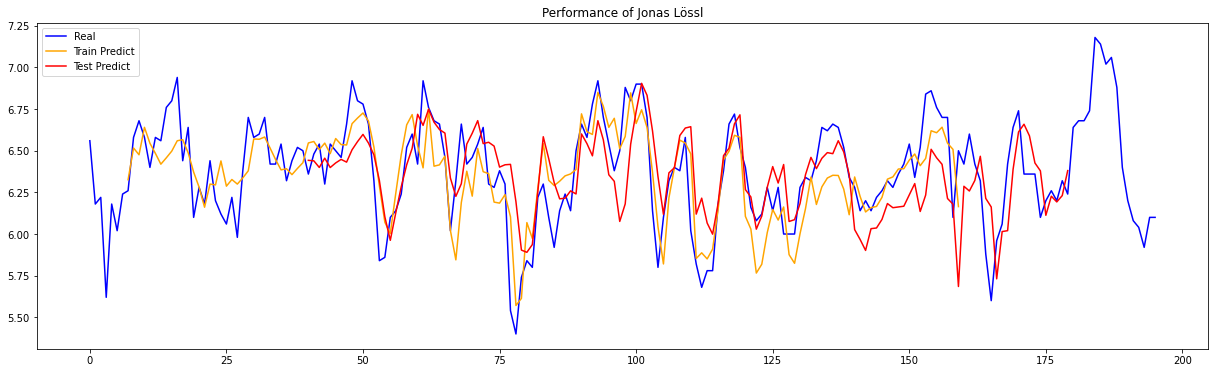

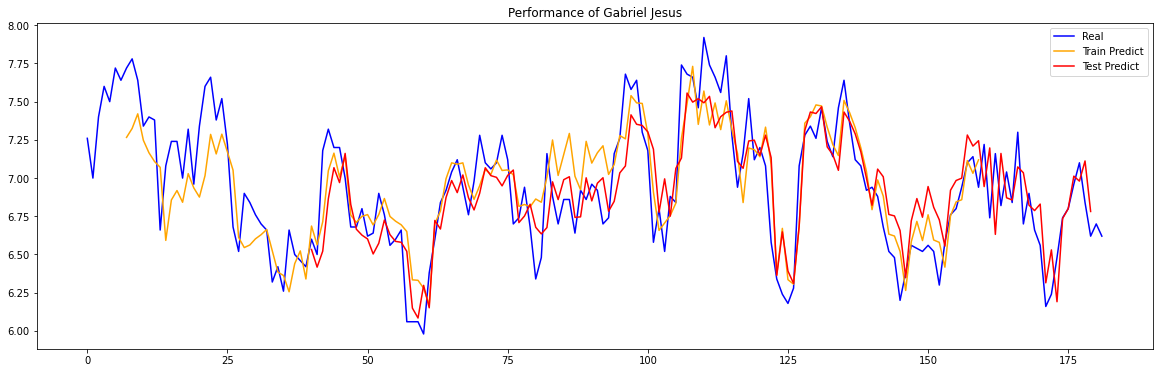

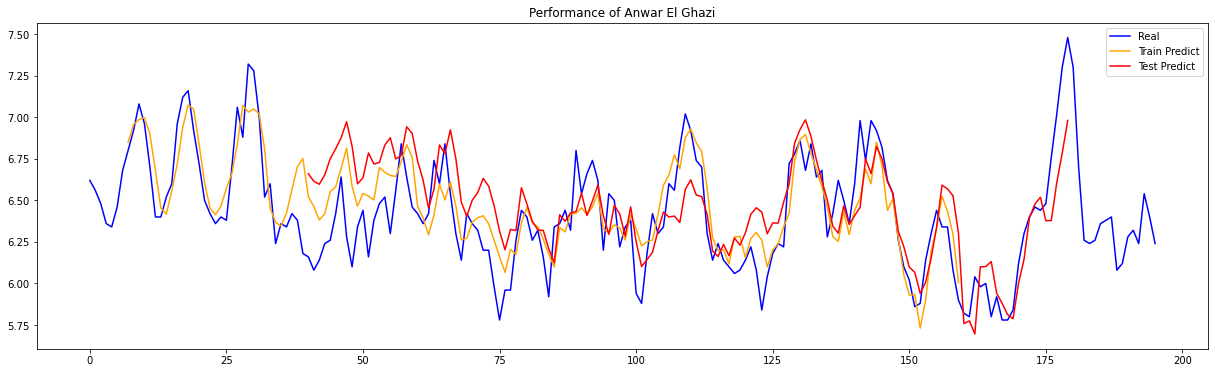

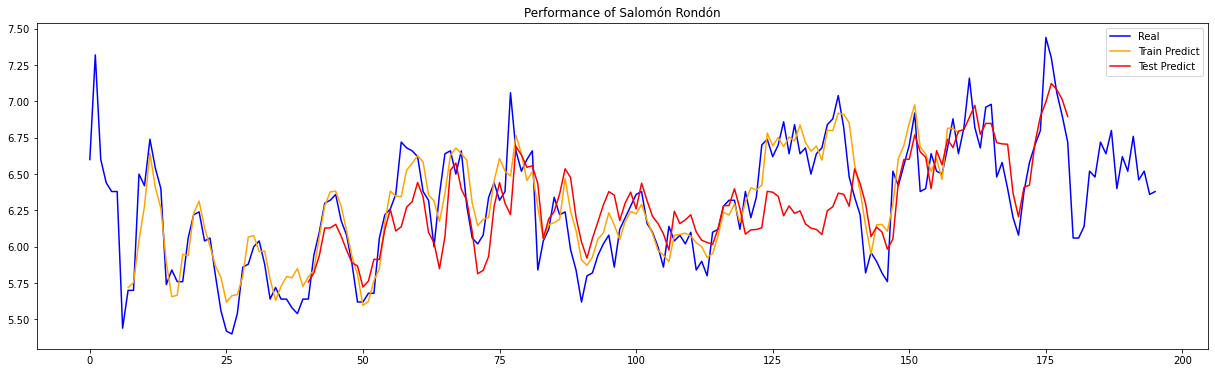

In [28]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_LSTM, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_LSTM.Filename,index=0)